## notebook 03a2: accuracy regression model on raw single trials

Here we present the same linear regression model as in our main analysis in notebook nb_03a_linear_regression_modelling_accuracy, but based on single trial data. We do not fulfil assumptions of normality of residuals or homoscedasticity, but show, that this model is in qualitative agreement with our main analysis.

### 0) preparation

#### imports

In [15]:
library(moments) # for skewness and kurtosis test
library(lme4) # for linear mixed effects models
library(ggplot2) # for plotting
library(ggpubr) # for qq plot
library(lmtest) # for likelihood ratio test
library(jtools) # for nice regression outputs
require(car)

In [16]:
# read in experiment results data
separator = .Platform$file.sep
data_path = paste("..", separator, "data", separator, "processed_data.csv", sep="") 
save_path = paste("..", separator, "data", separator, sep="")

data_raw = read.csv(data_path, skip=0)

#### read in data

In [17]:
# set up minimal dataframe
data <- data.frame(condition=data_raw$num_objects, session_num=data_raw$session_num,
                      ppid=data_raw$ppid, err_pos_walk=data_raw$err_pos_walk, 
                      num_objects=as.numeric(data_raw$num_objects))

# set column types as desired
data$condition_ordinal <- as.ordered(data$condition)
data$condition_categorical <- as.factor(data$condition)
data$session_num <- as.ordered(data$session_num)
data$ppid<- as.factor(data$ppid)

### 1) set up linear mixed model on trial basis

Also when calculating our established regression model on single trial data, we find a significant linear and a significant quadratic component.

[1] "AIC: 7893.48041207643"
[1] "BIC: 7942.22322029674"
[1] " ############## SUMMARY ##############"


MODEL INFO:
Observations: 3271
Dependent Variable: log(err_pos_walk)
Type: Mixed effects linear regression 

MODEL FIT:
AIC = 7893.48, BIC = 7942.22
Pseudo-R² (fixed effects) = 0.22
Pseudo-R² (total) = 0.38 

FIXED EFFECTS:
------------------------------------------------------------------
                             Est.   S.E.   t val.      d.f.      p
------------------------- ------- ------ -------- --------- ------
(Intercept)                  1.30   0.08    15.61     22.00   0.00
condition_ordinal.L         -0.77   0.03   -22.69   3243.05   0.00
condition_ordinal.Q          0.85   0.03    25.06   3243.03   0.00
condition_ordinal.C          0.04   0.03     1.10   3243.02   0.27
condition_ordinal^4         -0.14   0.03    -4.03   3243.00   0.00
condition_ordinal^5         -0.10   0.03    -2.94   3243.01   0.00
------------------------------------------------------------------

p values calculated using Kenward-Roger standard errors and
d.f.

RANDOM EFFECTS:
-----------------------

[1] " ############## RESIDUALS ##############"



	Shapiro-Wilk normality test

data:  residuals(mm_condition_ppid)
W = 0.98804, p-value = 5.402e-16


[1] " ############## HOMOSCEDASTICITY TEST ##############"


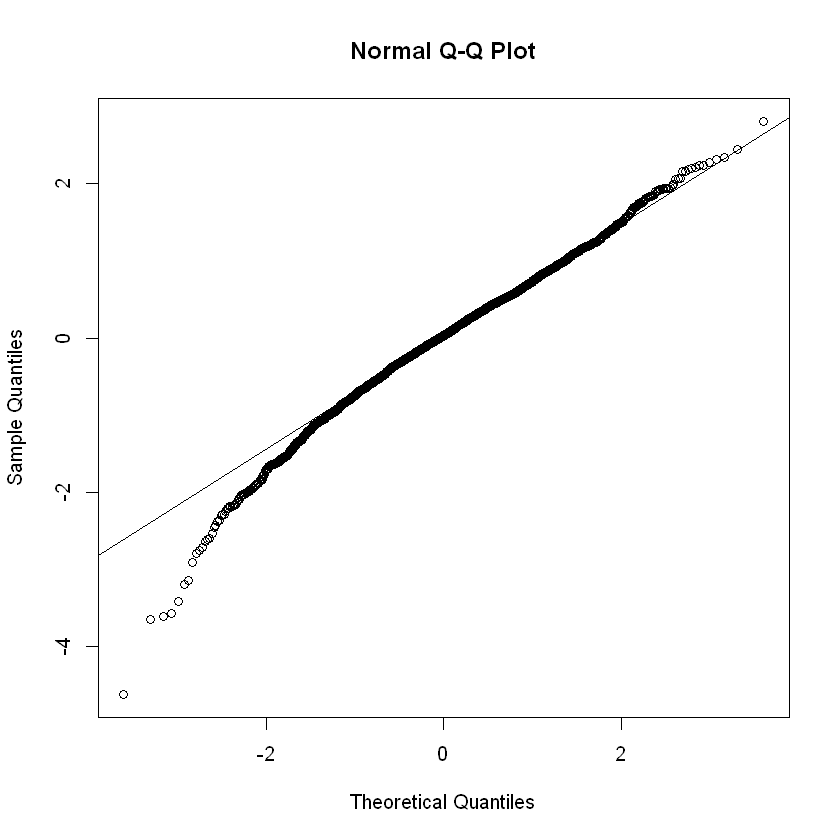

Df   F value  Pr(>F)      
group    5 22.45434 3.315477e-22
      3265       NA           NA

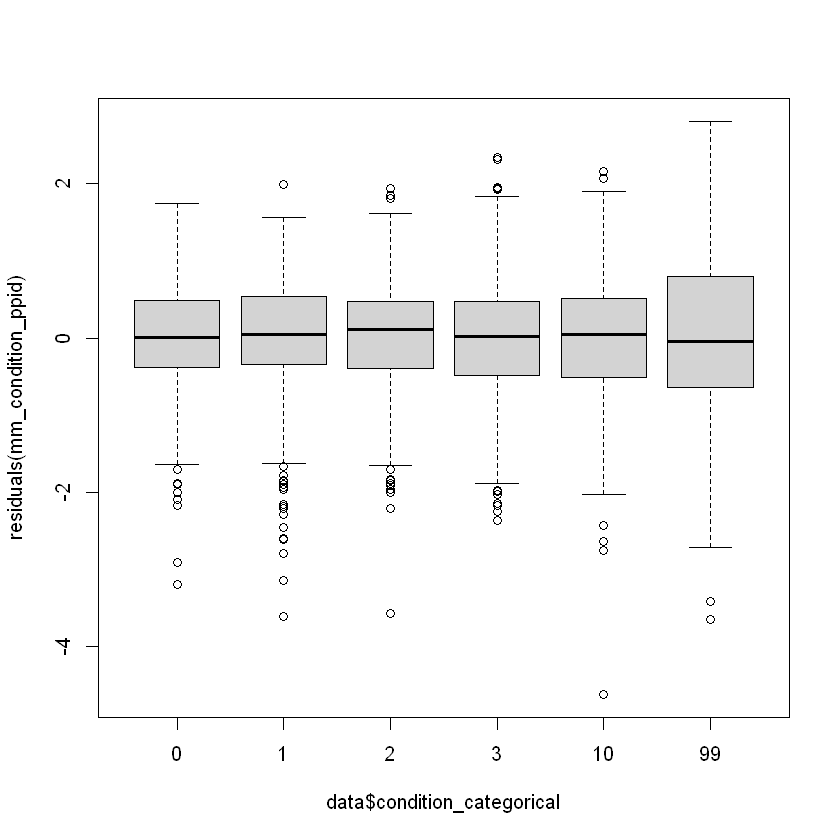

In [18]:
contrasts(data$condition_ordinal) = contr.poly(6)

mm_condition_ppid <- lmer(log(err_pos_walk) ~ condition_ordinal + (1|ppid), data=data)
# print information criteria
print(paste("AIC: ", AIC(mm_condition_ppid), sep=""))
print(paste("BIC: ", BIC(mm_condition_ppid), sep=""))

# linear model summary and residuals
print(" ############## SUMMARY ##############")
summ(mm_condition_ppid)
print(" ############## RESIDUALS ##############")
qqnorm(residuals(mm_condition_ppid))
qqline(residuals(mm_condition_ppid))
shapiro.test(residuals(mm_condition_ppid))
print(" ############## HOMOSCEDASTICITY TEST ##############")
boxplot(residuals(mm_condition_ppid) ~ data$condition_categorical)
leveneTest(residuals(mm_condition_ppid) ~ data$condition_categorical)

### 2) linear vs quadratic fit

Also when we fit our establsihed model on single trial data, we find a better quadratic than a linear fit for our data .

[1] "AIC linear: 8960.64122757739"
[1] "BIC linear: 8978.91978066"
[1] "AIC quadratic: 8493.86123902376"
[1] "BIC quadratic: 8518.23264313392"


#Df LogLik    Df Chisq  Pr(>Chisq)   
1 3   -4477.321 NA     NA            NA
2 4   -4242.931  1 468.78 5.905448e-104

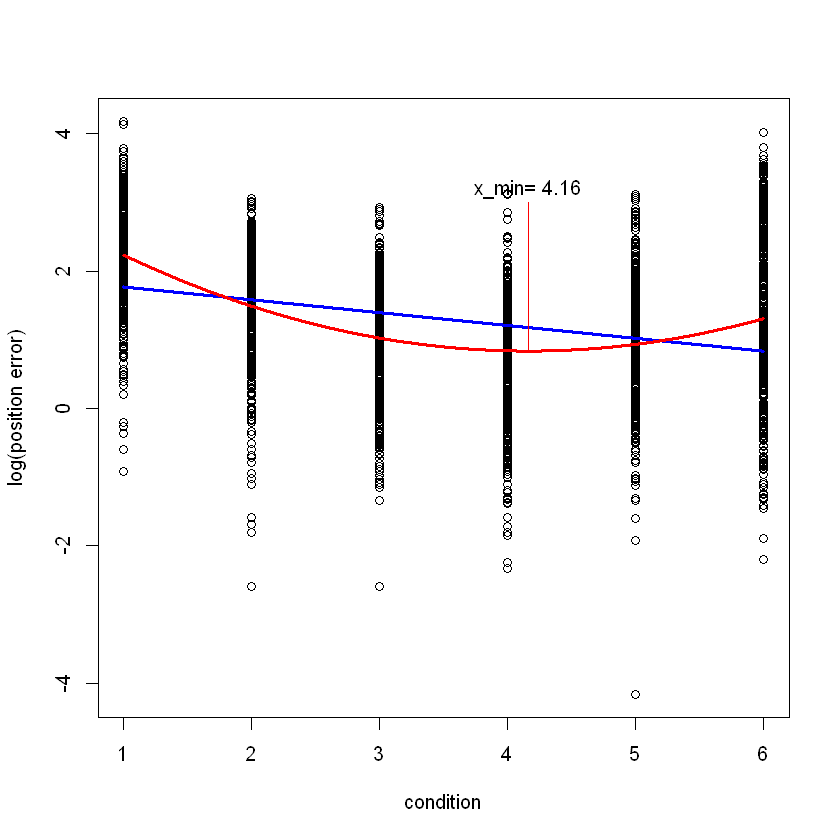

In [19]:
# fit a linear function to the position error
fit1 <- lm(log(data$err_pos_walk) ~ poly(unclass(data$condition_categorical),1,raw=TRUE))
# fit a quadratic function to the position error
fit2 <- lm(log(data$err_pos_walk) ~ poly(unclass(data$condition_categorical),2,raw=TRUE))
# define the x axis
x <- seq(min(unclass(data$condition_categorical)), max(unclass(data$condition_categorical)), length.out=1000)
# calculate the y-values for the linear and for the quadratic function
y1 <- fit1$coefficients[2]*x + fit1$coefficients[1]
y2 <- fit2$coefficients[3]*x^2 + fit2$coefficient[2]*x + fit2$coefficient[1]
# find the local minimum of the quadratic fit
fit_min <- -fit2$coefficients[2]/(2*fit2$coefficients[3])
y_min <- fit2$coefficients[3]*fit_min^2 + fit2$coefficient[2]*fit_min + fit2$coefficient[1]

# plot the raw data together with the linear and the quadratic fit
plot(unclass(data$condition_categorical), log(data$err_pos_walk), xlab="condition", ylab="log(position error)", pch=1)
lines(x,y1, col="blue", lw=3)
lines(x,y2, col="red", lw=3)
lines(c(fit_min, fit_min),c(y_min,3),col="red")
text(fit_min, 3.2, paste("x_min=", round(fit_min,2)))

# compare the linear and the quadratic fit
print(paste("AIC linear: ", AIC(fit1), sep=""))
print(paste("BIC linear: ", BIC(fit1), sep=""))
print(paste("AIC quadratic: ", AIC(fit2), sep=""))
print(paste("BIC quadratic: ", BIC(fit2), sep=""))
lrtest(fit1,fit2)